# Imports

In [1]:
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
#Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
#from torchvision.transforms import ToTensor
#from torchvision.utils import make_grid
#from torchvision.datasets.utils import download_url
import matplotlib
import matplotlib.pyplot as plt

# indicates to Jupyter that we want to plot the graphs within the notebook
%matplotlib inline
# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Image Classification generic model & functions

In [3]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### EXAMPLE MODEL CLASS
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return F.relu(self.conv2(x))
###

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [4]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# The problem-independent parts within a function called fit, which will be used
# to train the model. The problem-specific parts will be implemented by adding
# new methods to the nn.Module class.
# Configurations like batch size, learning rate, etc. (called hyperparameters),
# need to be picked in advance while training machine learning models.
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = [] # for recording epoch-wise results
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [5]:
def plot_accuracies(history):
    accuracies = [r['val_acc'] for r in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    accuracies = [r['val_loss'] for r in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

# Utils

In [6]:
# Utilities for moving out data & labels to the GPU, if one is available.
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

# ASL word-level recognition

## Load sign-MNIST datasets

In [7]:
# Other constants
num_rows = 27455
input_size = 28*28
output_size = 26

def int_to_char(num):
    return chr(num+65)

def plot_dataset(dataset):
    plt.figure(figsize=(9,7))
    for i in range(6):
        plt.subplot(2,3,i+1)
        image, label = dataset[i]
        plt.imshow(image.reshape(1,28,28)[0], cmap='gray')
        plt.xlabel(int_to_char(label.item()))
    plt.show()

In [8]:
# Load train dataframe
dataframe_raw = pd.read_csv('/content/data/sign_mnist/sign_mnist_train.csv')
dataframe_raw

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,194,193,193,194,194,195,195,196,194,195,196,196,197,196,197,197,196,195,195,189,190,192,192,193,194,195,196,196,196,193,...,115,92,132,173,118,84,53,135,253,213,219,208,82,82,84,85,85,87,84,87,78,113,216,189,172,175,155,131,116,93,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,167,169,169,169,169,169,169,169,169,169,167,167,167,166,165,164,164,163,162,153,156,159,160,162,163,164,165,167,169,172,...,199,200,199,199,198,199,198,197,196,195,195,194,66,67,65,62,61,41,32,37,33,30,28,38,187,202,199,199,199,199,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,173,173,172,171,171,171,170,169,168,166,166,165,165,163,162,161,160,158,156,178,178,177,176,177,177,177,176,176,176,175,...,110,85,90,166,205,207,205,203,202,201,200,198,217,217,217,218,218,211,203,200,189,171,157,145,136,129,128,125,101,77,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,190,191,193,192,191,191,191,191,190,190,189,187,186,184,183,182,181,179,177,179,182,185,187,189,190,192,192,192,192,194,...,190,173,140,80,28,60,70,61,61,78,100,86,136,135,135,135,132,132,136,136,137,144,103,120,197,200,195,196,170,149,119,56,27,58,102,79,47,64,87,93


Train dataset


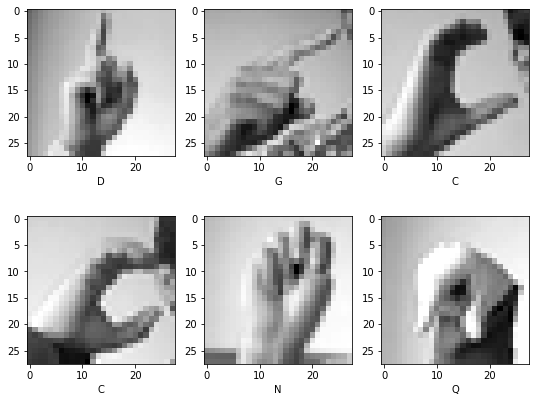

In [9]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1.drop(['label'], axis=1).to_numpy()
    targets_array = dataframe1['label'].to_numpy()
    return inputs_array, targets_array

inputs_array, targets_array = dataframe_to_arrays(dataframe_raw)

inputs = torch.from_numpy(inputs_array).type(torch.FloatTensor)
targets = torch.from_numpy(targets_array).type(torch.LongTensor)

# Train Dataset
dataset = TensorDataset(inputs, targets)
print('Train dataset')
plot_dataset(dataset)

Test dataset


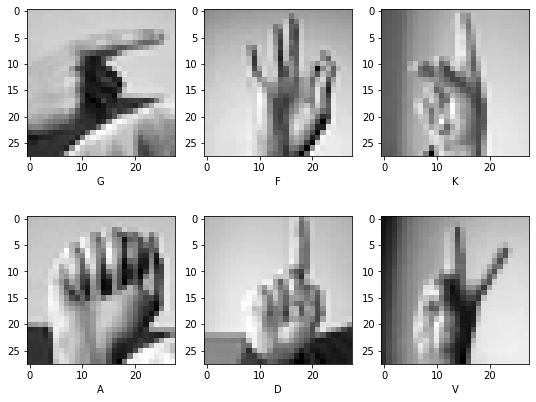

In [10]:
# Load test dataframe
df_test = pd.read_csv('/content/data/sign_mnist/sign_mnist_test.csv')

test_inputs_array, test_targets_array = dataframe_to_arrays(df_test)

test_inputs = torch.from_numpy(test_inputs_array).type(torch.FloatTensor)
test_targets = torch.from_numpy(test_targets_array).type(torch.LongTensor)

# Test Dataset
test_ds = TensorDataset(test_inputs, test_targets)
print('Test dataset')
plot_dataset(test_ds)

## Classification with logistic regression

In [ ]:
val_size = int(num_rows * 0.15)
train_size = num_rows - val_size

# Training validation
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

In [ ]:
batch_size = 128

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

In [ ]:
class SignMnistModel1(ImageClassificationBase):
    # we instantiate the weights and biases using nn.Linear
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
    
    # the forward method is invoked when we pass a batch of inputs to the model
    def forward(self, xb):
        # we flatten the input tensor and pass it into self.linear
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return out

In [ ]:
learning_rate = 0.01

# Training the model
model = SignMnistModel1()

history = [evaluate(model, val_loader)]
print(history)

history += fit(2, learning_rate, model, train_loader, val_loader)
history += fit(2, learning_rate, model, train_loader, val_loader)
history += fit(2, learning_rate/10, model, train_loader, val_loader)

In [ ]:
plot_accuracies(history)

In [ ]:
# Save a model
# The .state_dict method returns an OrderedDict containing all the weights and
# bias matrices mapped to the right attributes of the model.
torch.save(model.state_dict(), 'sign-mnist-logistic.pth')

## To load the model weights, we can instante a new object of the class
## MyModel, and use the .load_state_dict method.
#my_model = MyModel()
#my_model.load_state_dict(torch.load('sign-mnist-logistic.pth'))

### Test

In [ ]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

In [ ]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

In [ ]:
def plot_prediction(dataset):
    plt.figure(figsize=(15,7))
    for i in range(10):
        plt.subplot(2,5,i+1)
        image, label = dataset[i]
        plt.imshow(image.reshape(1,28,28)[0], cmap='gray')
        lbl = 'Label:'+int_to_char(label.item())+', Predicted:'+int_to_char(predict_image(image, model))
        plt.xlabel(lbl)
    plt.show()

plot_prediction(test_ds)

## Classification with CNN

In [12]:
val_size = int(num_rows * 0.15)
train_size = num_rows - val_size

# Training validation
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

# Create data loaders to load the data in batches
batch_size = 128

train_loader2 = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader2 = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader2 = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

# Move data loaders to the appropriate device
train_loader2 = DeviceDataLoader(train_loader2, device)
val_loader2 = DeviceDataLoader(val_loader2, device)
test_loader2 = DeviceDataLoader(test_loader2, device)

In [13]:
class SignMnistModelCNN(ImageClassificationBase):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, 16)
        # hidden layer 2
        self.linear2 = nn.Linear(16, 32)
        # output layer
        self.linearO = nn.Linear(32, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linearO(out)
        #out = F.relu(out)
        return out

In [14]:
model2 = SignMnistModelCNN(input_size, output_size)
to_device(model2, device)

SignMnistModelCNN(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linearO): Linear(in_features=32, out_features=26, bias=True)
)

In [15]:
history2 = [evaluate(model2, val_loader2)]
history2

[{'val_acc': 0.06295955926179886, 'val_loss': 21.923477172851562}]

In [19]:
history2 += fit(5, 0.1, model2, train_loader2, val_loader2)

Epoch [0], val_loss: 3.1764, val_acc: 0.0445
Epoch [1], val_loss: 3.1762, val_acc: 0.0445
Epoch [2], val_loss: 3.1765, val_acc: 0.0445
Epoch [3], val_loss: 3.1767, val_acc: 0.0445
Epoch [4], val_loss: 3.1765, val_acc: 0.0445


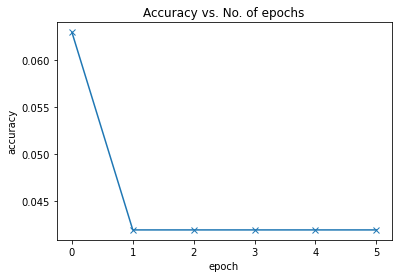

In [17]:
plot_accuracies(history2)

In [ ]:
result2 = evaluate(model2, test_loader2)
result2